# Example: Transit mask
If transits have already been discovered, it is best practice to mask them while detrending. This way, the in-transit data points can not influence the detrending. The current version only supports the ``cosine`` and ``lowess`` methods. Additional methods are planned for future releases.

We begin our example by downloading a TESS dataset:

In [1]:
import numpy as np
from astropy.io import fits

def load_file(filename):
    """Loads a TESS *spoc* FITS file and returns TIME, PDCSAP_FLUX"""
    hdu = fits.open(filename)
    time = hdu[1].data['TIME']
    flux = hdu[1].data['PDCSAP_FLUX']
    flux[flux == 0] = np.nan
    return time, flux

path = 'https://archive.stsci.edu/hlsps/tess-data-alerts/'
filename = 'hlsp_tess-data-alerts_tess_phot_00207081058-s01_tess_v1_lc.fits'
time, flux = load_file(path + filename)

We detrend these data blindly (without masking) to prepare for a transit search:

In [2]:
from wotan import flatten
flatten_lc1, trend_lc1 = flatten(
    time,
    flux,
    method='cosine',
    window_length=0.4,
    return_trend=True,
    robust=True
    )

Iteration: 1 Rejected outliers (total): 176
Iteration: 2 Rejected outliers (total): 148
Converged.
Iteration: 1 Rejected outliers (total): 179
Iteration: 2 Rejected outliers (total): 156
Iteration: 3 Rejected outliers (total): 154
Converged.


We plot the result:

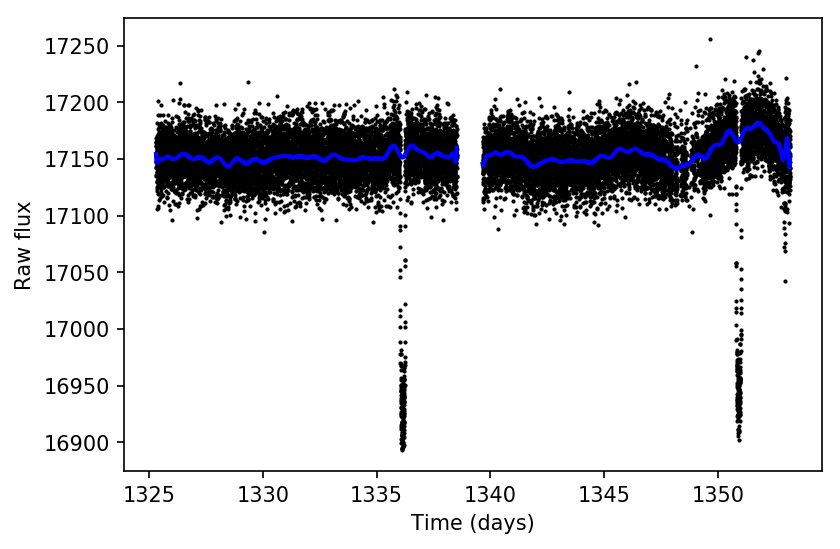

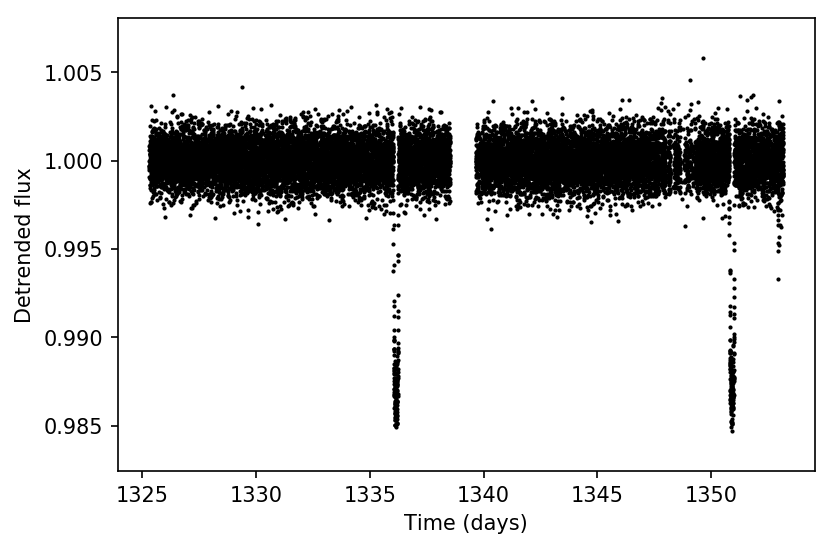

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc1, color='blue', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.show();
plt.close()
plt.scatter(time, flatten_lc1, s=1, color='black')
plt.xlabel('Time (days)')
plt.ylabel('Detrended flux');

There appear to be 2 transits in the data. We use the ``transitleastsquares`` package to get the ephemeris:

In [5]:
from transitleastsquares import transitleastsquares
model = transitleastsquares(time, flatten_lc1)
results = model.power(n_transits_min=1)
print('Period (days)', format(results.period, '.5f'))
print('Duration (days)', format(results.duration, '.5f'))
print('T0 (days)', results.T0)

  0%|          | 0/2838 periods | 00:00<?

Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 33 durations
Searching 18123 data points, 2838 periods from 0.601 to 27.879 days
Using all 8 CPU threads


100%|██████████| 2838/2838 periods | 00:12<00:00
  0%|          | 8/5981 [00:00<01:14, 79.90it/s]

Searching for best T0 for period 14.77338 days


100%|██████████| 5981/5981 [00:02<00:00, 2752.15it/s]


Period (days) 14.77338
Duration (days) 0.21060
T0 (days) 1336.1410955058836


These parameters look sensible. We can visually verify that the in-transit points have been determined correctly. For this, we use the feature ``transit_mask`` in ``wotan``:

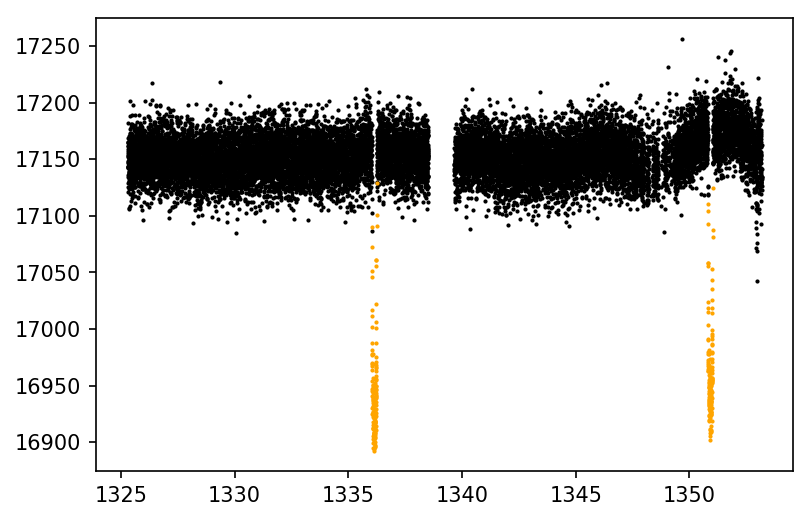

In [6]:
from wotan import transit_mask
mask = transit_mask(
    time=time,
    period=results.period,
    duration=results.duration,
    T0=results.T0)

plt.scatter(time[~mask], flux[~mask], s=1, color='black')
plt.scatter(time[mask], flux[mask], s=1, color='orange')
plt.show()
plt.close()

That looks good. We can now use this mask to refine our detrending with the knowledge of the in-transit points. More precisely, we instruct the detrender to ignore these points, by setting their weight to zero.

In [7]:
flatten_lc2, trend_lc2 = flatten(
    time,
    flux,
    method='cosine',
    window_length=0.4,
    return_trend=True,
    robust=True,
    mask=mask
    )

Iteration: 1 Rejected outliers (total): 150
Converged.
Iteration: 1 Rejected outliers (total): 153
Converged.


Let's plot both trends to compare the difference of the blind detrending (blue) and the masked one (red):

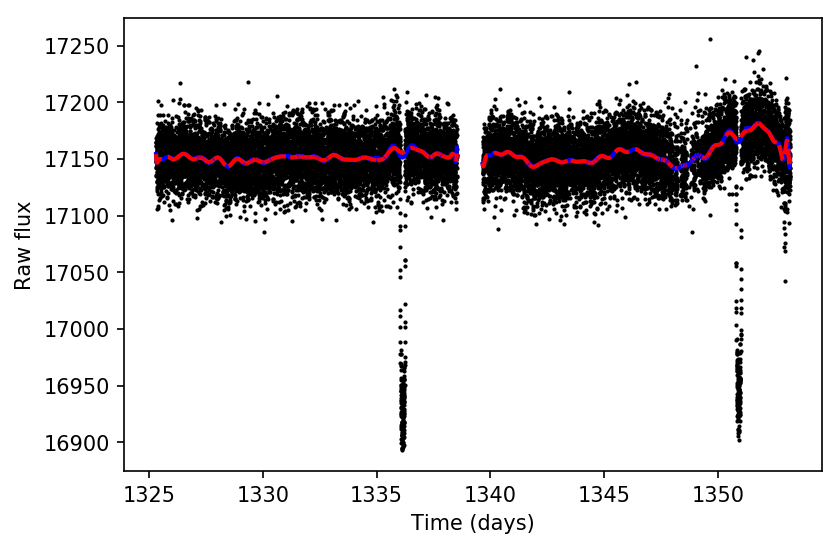

In [8]:
plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc1, color='blue', linewidth=2)
plt.plot(time, trend_lc2, color='red', linewidth=2, linestyle='dashed')
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.show()
plt.close();

When zooming into the transit, we can see the effect more clearly:

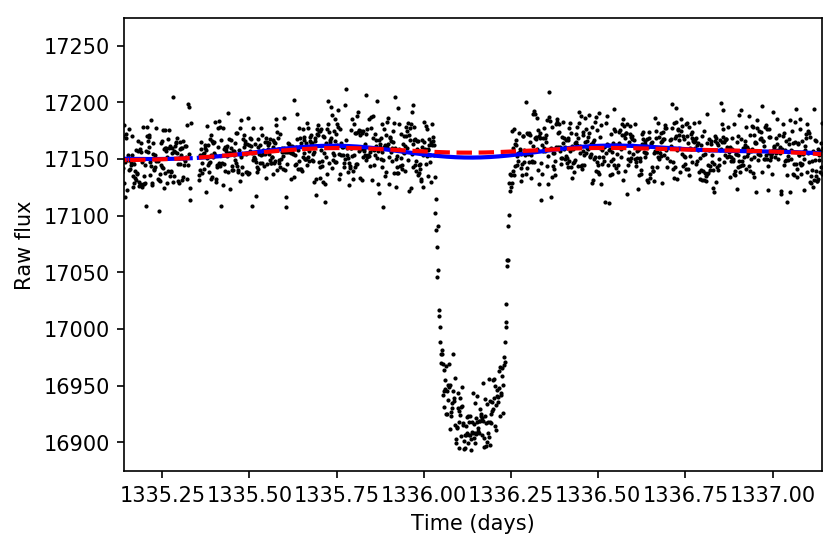

In [9]:
plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc1, color='blue', linewidth=2)
plt.plot(time, trend_lc2, color='red', linewidth=2, linestyle='dashed')
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.xlim(results.T0 - 1, results.T0 + 1)
plt.show()
plt.close();

Excellent! The red trend (using the transit mask) gives a perfect estimate for further analysis.